In [1]:
import os
import sys
import shutil

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import region_formatter, path_utils

In [4]:
pathUtils = path_utils.PathUtils()

In [5]:
fig_plots = []

In [6]:
git_root_path = pathUtils.get_git_root(os.getcwd())
dataframes_path = "{}/dataframes".format(git_root_path)

In [7]:
%run ../dataframes/provinces_gdf.ipynb -i
provinces_gdf = pd.read_pickle("{}/provinces_gdf.pkl".format(dataframes_path))

In [8]:
%run ../dataframes/asl.ipynb -i
df_asl = pd.read_pickle("{}/df_asl.pkl".format(dataframes_path))

In [9]:
%run ../dataframes/dism_first_access.ipynb -i
df_dism_first_access = pd.read_pickle("{}/df_dism_first_access.pkl".format(dataframes_path))

In [10]:
newcmp = LinearSegmentedColormap.from_list("", ["#a3b18a", "#588157","#3a5a40"])

In [11]:
### Constants
OUTPUT_DIR = "output"
TARGET_GROUP = "Depressione"
TARGET_GROUP_TEXT = "Depressione"
YEAR = "2022"
# CMAP = (ListedColormap(['cyan', 'yellow', 'orange']))
CMAP = newcmp

In [12]:
plt.rcParams["figure.figsize"] = [7.50, 5.50]
plt.rcParams["figure.autolayout"] = True

In [13]:
REGION_COLOURS = {
    "Nord": "#344e41", 
    "Centro": "#588157",
    "Sud e Isole": "#dad7cd",
}

In [14]:
if not os.path.exists(OUTPUT_DIR):
    # Create the directory
    os.makedirs(OUTPUT_DIR)

In [15]:
folder = OUTPUT_DIR
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

# prepare dataframe

In [16]:
df = df_dism_first_access.loc[df_dism_first_access["gruppo_diagnostico"] == TARGET_GROUP, [
    "codice_asl", 
    "descrizione_regione",
    "sesso",
    "numero_accessi",
    "asl"
]]

In [17]:
df

,codice_asl,descrizione_regione,sesso,numero_accessi,asl
4,203,PIEMONTE,Maschio,1606,to3
15,203,PIEMONTE,Femmina,3129,to3
26,204,PIEMONTE,Maschio,1557,to4
37,204,PIEMONTE,Femmina,2785,to4
48,205,PIEMONTE,Maschio,549,to5
...,...,...,...,...,...
2865,305,SARDEGNA,Femmina,344,asl n. 5 di oristano
2875,306,SARDEGNA,Maschio,70,asl n. 6 del medio campidano
2884,306,SARDEGNA,Femmina,128,asl n. 6 del medio campidano
2894,308,SARDEGNA,Maschio,604,asl n. 8 di cagliari


In [18]:
df_asl = df_asl.loc[df_asl["anno"] == int(YEAR), ]

In [19]:
df_asl = df_asl[["codice_azienda", "sigla_provincia", "denominazione_azienda"]]

In [20]:
df_asl

,codice_azienda,sigla_provincia,denominazione_azienda
1480,203,TO,to3
1481,204,TO,to4
1482,205,TO,to5
1483,206,VC,vc
1484,207,BI,bi
...,...,...,...
1581,304,NU,asl n. 4 dell'ogliastra
1582,305,OR,asl n. 5 di oristano
1583,306,SU,asl n. 6 del medio campidano
1584,307,SU,asl n. 7 del sulcis


In [21]:
provinces_gdf = provinces_gdf[["prov_acr", "geometry", "zone", "prov_name"]]

In [22]:
df = df.set_index("asl").join(df_asl.set_index("denominazione_azienda"))

In [23]:
assert df.loc[df["descrizione_regione"] == "LAZIO", ]['numero_accessi'].sum() == 60001

In [24]:
assert df.loc[df["descrizione_regione"] == "CALABRIA", ]['numero_accessi'].sum() == 18221

In [25]:
assert df.loc[df["descrizione_regione"] == "LOMBARDIA", ]['numero_accessi'].sum() == 136045

In [26]:
df_asl_agg = df_asl.pivot_table(
    index='sigla_provincia',
    aggfunc='count',
)

In [27]:
df_asl_agg

,codice_azienda,denominazione_azienda
sigla_provincia,,
AG,1,1
AL,1,1
AN,1,1
AO,1,1
AQ,1,1
...,...,...
VE,2,2
VI,2,2
VR,1,1


In [28]:
df_asl_agg = df_asl_agg.rename(columns={
    "codice_azienda": "asl_count",
})

In [29]:
df = df.reset_index()

In [30]:
df = df.pivot_table(
    index='sigla_provincia',
    aggfunc='sum',
    values='numero_accessi'
)

In [31]:
df

,numero_accessi
sigla_provincia,
AG,2991
AL,2402
AN,11041
AO,1524
AQ,3358
...,...
VE,11235
VI,7337
VR,6768


In [32]:
df = df.join(df_asl_agg)

In [33]:
df = df.assign(target_group_avg=lambda df_: df_.numero_accessi / df_.asl_count)

In [34]:
df

,numero_accessi,asl_count,denominazione_azienda,target_group_avg
sigla_provincia,,,,
AG,2991,1,1,2991.0
AL,2402,1,1,2402.0
AN,11041,1,1,11041.0
AO,1524,1,1,1524.0
AQ,3358,1,1,3358.0
...,...,...,...,...
VE,11235,2,2,5617.5
VI,7337,2,2,3668.5
VR,6768,1,1,6768.0


In [35]:
df = provinces_gdf.set_index("prov_acr").join(df)

In [36]:
df

,geometry,zone,prov_name,numero_accessi,asl_count,denominazione_azienda,target_group_avg
prov_acr,,,,,,,
TO,"POLYGON ((7.89397 45.58222, 7.89654 45.57985, ...",Nord,Torino,19741.0,4.0,4.0,4935.25
VC,"POLYGON ((7.92900 45.74244, 7.92584 45.74196, ...",Nord,Vercelli,1046.0,1.0,1.0,1046.00
NO,"POLYGON ((8.42079 45.82981, 8.42028 45.83010, ...",Nord,Novara,2926.0,1.0,1.0,2926.00
CN,"MULTIPOLYGON (((6.94540 44.42794, 6.94734 44.4...",Nord,Cuneo,6049.0,2.0,2.0,3024.50
AT,"POLYGON ((7.96685 45.11667, 7.96729 45.11673, ...",Nord,Asti,2000.0,1.0,1.0,2000.00
...,...,...,...,...,...,...,...
SS,"MULTIPOLYGON (((9.46502 40.65584, 9.46475 40.6...",Sud e Isole,Sassari,440.0,2.0,2.0,220.00
NU,"MULTIPOLYGON (((9.28037 39.91741, 9.27741 39.9...",Sud e Isole,Nuoro,681.0,2.0,2.0,340.50
CA,"MULTIPOLYGON (((8.84872 39.09924, 8.84697 39.1...",Sud e Isole,Cagliari,1963.0,1.0,1.0,1963.00


In [37]:
plot_title = "Totale accessi con diagnosi '{}'\n per DISM per provincia - Anno {}".format(
    TARGET_GROUP_TEXT,
    YEAR
)

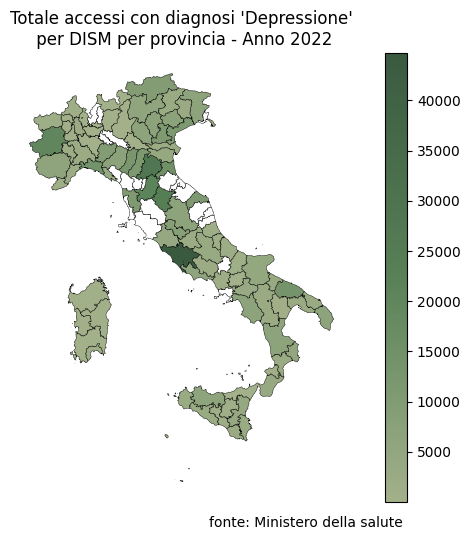

In [38]:
df_plot = df.plot(
    column="numero_accessi",
    legend=True,
    cmap=CMAP,
    edgecolor="black",
    linewidth=0.3,
    missing_kwds={
        "color": "white",
        "edgecolor": "black",
        "label": "Missing values",
    }
);
plt.title(plot_title)
df_plot.set_axis_off()
plt.annotate('fonte: Ministero della salute', (0,0), (140, -10), xycoords='axes fraction', textcoords='offset points', va='top')
fig_plots.append({
    "df": df_plot,
    "name": plot_title
})

Text(260, -30, 'fonte: Ministero della salute')

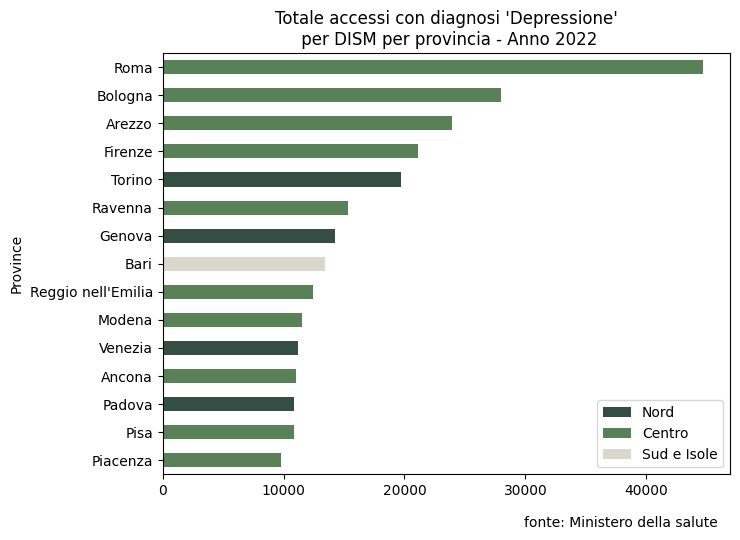

In [39]:
best_rows = df.sort_values(by=['numero_accessi'], ascending=False).head(15)
best_rows_sorted = best_rows.sort_values(by=['numero_accessi'])
df_plot = best_rows_sorted.plot.barh(
    title=plot_title,
    y="numero_accessi",
    x="prov_name",
    ylabel='Province',
    color=best_rows_sorted['zone'].replace(REGION_COLOURS)
).legend(
    [
        Patch(facecolor=REGION_COLOURS['Nord']),
        Patch(facecolor=REGION_COLOURS['Centro']),
        Patch(facecolor=REGION_COLOURS['Sud e Isole']),
    ], ["Nord", "Centro", 'Sud e Isole']
)
plt.annotate('fonte: Ministero della salute', (0,0), (260, -30), xycoords='axes fraction', textcoords='offset points', va='top')

In [40]:
best_rows

,geometry,zone,prov_name,numero_accessi,asl_count,denominazione_azienda,target_group_avg
prov_acr,,,,,,,
RM,"MULTIPOLYGON (((11.82281 42.14649, 11.82464 42...",Centro,Roma,44690.0,6.0,6.0,7448.333333
BO,"POLYGON ((11.13161 44.56743, 11.12953 44.56816...",Centro,Bologna,27985.0,2.0,2.0,13992.500000
AR,"MULTIPOLYGON (((12.10273 43.52993, 12.09576 43...",Centro,Arezzo,23903.0,1.0,1.0,23903.000000
FI,"POLYGON ((11.20242 44.10074, 11.20259 44.10067...",Centro,Firenze,21124.0,1.0,1.0,21124.000000
TO,"POLYGON ((7.89397 45.58222, 7.89654 45.57985, ...",Nord,Torino,19741.0,4.0,4.0,4935.250000
RA,"POLYGON ((11.88393 44.57916, 11.88897 44.58038...",Centro,Ravenna,15315.0,1.0,1.0,15315.000000
GE,"MULTIPOLYGON (((8.62924 44.43798, 8.63001 44.4...",Nord,Genova,14260.0,2.0,2.0,7130.000000
BA,"MULTIPOLYGON (((17.29774 40.82012, 17.29722 40...",Sud e Isole,Bari,13465.0,1.0,1.0,13465.000000
RE,"POLYGON ((10.66820 44.46778, 10.66702 44.46700...",Centro,Reggio nell'Emilia,12433.0,1.0,1.0,12433.000000


In [41]:
plot_title = "Media accessi con diagnosi '{}'\n per DISM per provincia - Anno {}".format(
    TARGET_GROUP_TEXT,
    YEAR
)

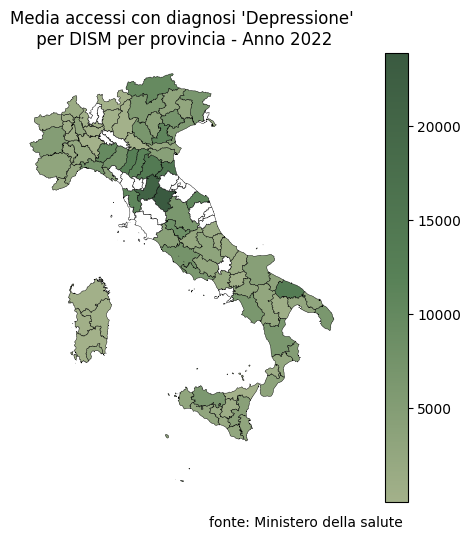

In [42]:
df_plot = df.plot(
    column="target_group_avg",
    legend=True,
    cmap=CMAP,
    edgecolor="black",
    linewidth=0.3,
    missing_kwds={
        "color": "white",
        "edgecolor": "black",
        "label": "Missing values",
    }
);
plt.title(plot_title)
df_plot.set_axis_off()
plt.annotate('fonte: Ministero della salute', (0,0), (140, -10), xycoords='axes fraction', textcoords='offset points', va='top')
fig_plots.append({
    "df": df_plot,
    "name": plot_title
})

Text(260, -30, 'fonte: Ministero della salute')

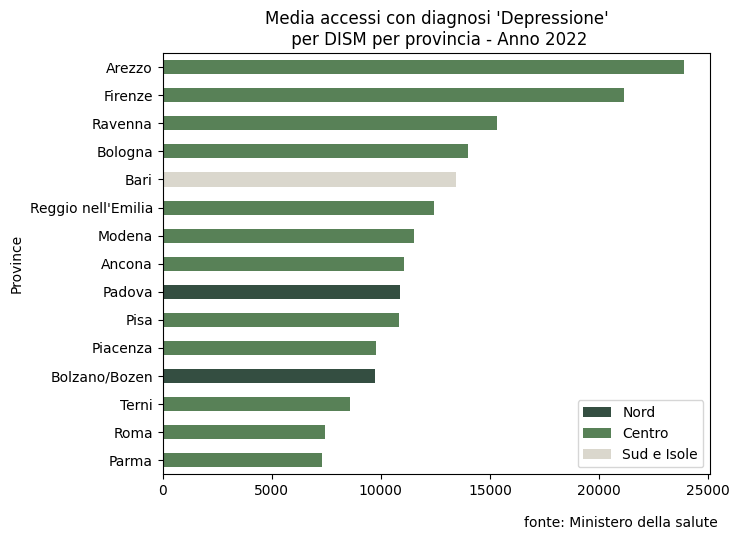

In [43]:
best_rows = df.sort_values(by=['target_group_avg'], ascending=False).head(15)
best_rows_sorted = best_rows.sort_values(by=['target_group_avg'])
df_plot = best_rows_sorted.plot.barh(
    title=plot_title,
    x="prov_name",
    y="target_group_avg",
    ylabel='Province',
    color=best_rows_sorted['zone'].replace(REGION_COLOURS)
).legend(
    [
        Patch(facecolor=REGION_COLOURS['Nord']),
        Patch(facecolor=REGION_COLOURS['Centro']),
        Patch(facecolor=REGION_COLOURS['Sud e Isole']),
    ], ["Nord", "Centro", 'Sud e Isole']
)
plt.annotate('fonte: Ministero della salute', (0,0), (260, -30), xycoords='axes fraction', textcoords='offset points', va='top')

In [44]:
plot_title = "Numero di DISM per provincia - Anno {}".format(
    TARGET_GROUP_TEXT,
    YEAR
)

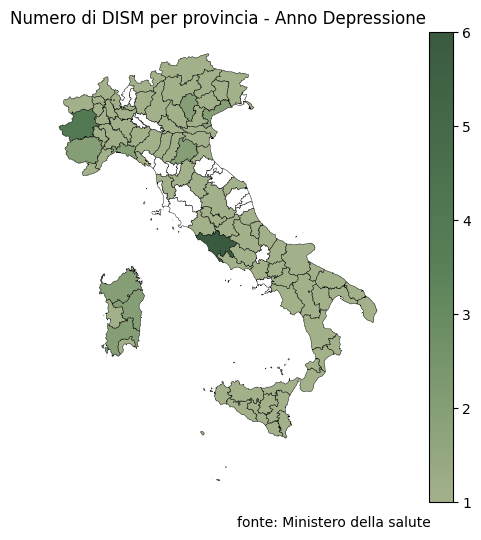

In [45]:
df_plot = df.plot(
    column="asl_count",
    legend=True,
    cmap=CMAP,
    edgecolor="black",
    linewidth=0.3,
    missing_kwds={
        "color": "white",
        "edgecolor": "black",
        "label": "Missing values",
    }
);
plt.title(plot_title)
df_plot.set_axis_off()
plt.annotate('fonte: Ministero della salute', (0,0), (140, -10), xycoords='axes fraction', textcoords='offset points', va='top')
fig_plots.append({
    "df": df_plot,
    "name": plot_title
})

Text(260, -30, 'fonte: Ministero della salute')

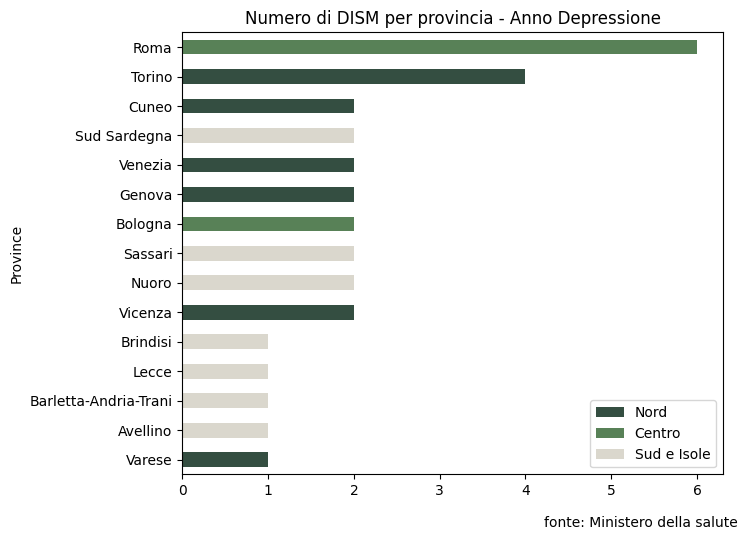

In [46]:
best_rows = df.sort_values(by=['asl_count'], ascending=False).head(15)
best_rows_sorted = best_rows.sort_values(by=['asl_count'])
df_plot = best_rows_sorted.plot.barh(
    title=plot_title,
    x="prov_name",
    y="asl_count",
    ylabel='Province',
    color=best_rows_sorted['zone'].replace(REGION_COLOURS)
).legend(
    [
        Patch(facecolor=REGION_COLOURS['Nord']),
        Patch(facecolor=REGION_COLOURS['Centro']),
        Patch(facecolor=REGION_COLOURS['Sud e Isole']),
    ], ["Nord", "Centro", 'Sud e Isole']
)
plt.annotate('fonte: Ministero della salute', (0,0), (260, -30), xycoords='axes fraction', textcoords='offset points', va='top')

In [47]:
for i, fig_plot in enumerate(fig_plots, start=1):
    df_ = fig_plot.get("df")
    df_name = fig_plot.get("name")
    file_name = "{}/{}_{}.png".format(OUTPUT_DIR, i, df_name)
    df_.get_figure().savefig(file_name)